# Drug Review Analysis

In [ ]:
#!pip install imblearn
#!pip install vaderSentiment

In [397]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from IPython.display import display_html
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from statistics import median

sns.set_theme()

## Initial data import and analysis

In [4]:
train_data = pd.read_csv('drugLib_raw/drugLibTrain_raw.tsv', sep='\t', header=0, names=['id', 'drug', 'rating', 'effectiveness', 'side_effects', 'condition', 'benefits_review', 'side_effects_review', 'comments_review'])
train_data.head()

,id,drug,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,comments_review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


### Droping 'id' column because it doesn't add any relevant information

In [5]:
train_data.drop(columns='id', inplace=True)
train_data.head()

,drug,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,comments_review
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


### Checking data types and presence of NaNs

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   drug                 3107 non-null   object
 1   rating               3107 non-null   int64 
 2   effectiveness        3107 non-null   object
 3   side_effects         3107 non-null   object
 4   condition            3106 non-null   object
 5   benefits_review      3107 non-null   object
 6   side_effects_review  3105 non-null   object
 7   comments_review      3099 non-null   object
dtypes: int64(1), object(7)
memory usage: 194.3+ KB


In [7]:
# Checking which columns have NaNs
train_data.isna().any()

drug                   False
rating                 False
effectiveness          False
side_effects           False
condition               True
benefits_review        False
side_effects_review     True
comments_review         True
dtype: bool

In [8]:
# Checking how many rows are affected by NaNs
train_data[train_data.isna().any(axis=1)].shape[0]

11

In [9]:
# Visualizing the rows that have NaNs
train_data[train_data.isna().any(axis=1)]

,drug,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,comments_review
147,doxycycline,4,Moderately Effective,Severe Side Effects,epididymitus,Treatment cleared up the infection.,Treatment ended 2 months ago and have still go...,NaN
400,hyzaar,8,Highly Effective,Moderate Side Effects,hypertension,Pills helped to lower my blood pressure. Also...,"Back pain, especially after a missed dose. In...",NaN
407,ritalin-la,8,Considerably Effective,Mild Side Effects,adhd,This medication enabled me to think clearly. ...,"This medication caused me to be nervous, tremb...",NaN
1238,seasonique,9,Highly Effective,Mild Side Effects,prevent menstral migranes,Experienced 1 migrane in the past year since o...,Noticed light skin iritation. Take the light ...,NaN
1468,seasonique,4,Considerably Effective,Moderate Side Effects,preventing pregnancy,preventing pregnancy,This pill was great b/c i didn't have any peri...,NaN
1965,xenical,3,Marginally Effective,No Side Effects,over weight,i have been on xenical for a little over 2 wee...,i dont have any other then now i am constipated,NaN
2402,levothroid,10,Highly Effective,No Side Effects,thyroid,balancing of thyroid back to normal range. Pri...,NaN,.1mg daily orally.
2488,keflex,2,Ineffective,No Side Effects,NaN,None. I had a bacterial infection accompanyin...,The only good point I suppose is that there wa...,Absoutely innefective. I easily could have be...
2705,flonase,8,Considerably Effective,No Side Effects,plugged up nose related to seasonal allergies,cleared up nose,none,NaN
2891,doxycycline,6,Moderately Effective,No Side Effects,acne,Controlled acne breakouts to some extent when ...,NaN,Took Doxylin 50 mg once daily for 3 months. I...


### Handling NaNs

In [10]:
# The NaNs present on the side_effects_reviews column correspond to drugs that had no side effects.
# Since we have a small dataset, it was decided to fill those NaNs with a string saying 'no side effects'.
train_data.fillna({'side_effects_review': 'no side effects'}, inplace=True)

# Checking if it worked
#train_data[train_data.isna().any(axis=1)].shape

In [11]:
train_data[train_data.isna().any(axis=1)]

,drug,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,comments_review
147,doxycycline,4,Moderately Effective,Severe Side Effects,epididymitus,Treatment cleared up the infection.,Treatment ended 2 months ago and have still go...,NaN
400,hyzaar,8,Highly Effective,Moderate Side Effects,hypertension,Pills helped to lower my blood pressure. Also...,"Back pain, especially after a missed dose. In...",NaN
407,ritalin-la,8,Considerably Effective,Mild Side Effects,adhd,This medication enabled me to think clearly. ...,"This medication caused me to be nervous, tremb...",NaN
1238,seasonique,9,Highly Effective,Mild Side Effects,prevent menstral migranes,Experienced 1 migrane in the past year since o...,Noticed light skin iritation. Take the light ...,NaN
1468,seasonique,4,Considerably Effective,Moderate Side Effects,preventing pregnancy,preventing pregnancy,This pill was great b/c i didn't have any peri...,NaN
1965,xenical,3,Marginally Effective,No Side Effects,over weight,i have been on xenical for a little over 2 wee...,i dont have any other then now i am constipated,NaN
2488,keflex,2,Ineffective,No Side Effects,NaN,None. I had a bacterial infection accompanyin...,The only good point I suppose is that there wa...,Absoutely innefective. I easily could have be...
2705,flonase,8,Considerably Effective,No Side Effects,plugged up nose related to seasonal allergies,cleared up nose,none,NaN
2921,ceclor,1,Ineffective,Severe Side Effects,ear infection,My son had an allergic reaction. He broke out...,Time - let them go away on their own,NaN


In [12]:
# Trying to infer the condition that was being treated.
# This column might be usefull for a more complex model, that also uses the rating and condition columns, 
# to predict the effectiveness and side_effects rating.
print('Benefits : ', train_data.loc[2488]['benefits_review'])
print('\nSide effects : ', train_data.loc[2488]['side_effects_review'],'\n')
print(train_data[train_data['drug'] == 'keflex']['condition'])

# Having determined that the condition was a bacterial infection, lets fill the NaN with it.
train_data.fillna({'condition': 'bacterial infection'}, inplace=True)


Benefits :  None.  I had a bacterial infection accompanying my flu and there wasnt a single noticeable benefit.

Side effects :  The only good point I suppose is that there was no adverse reaction, such as yeast infection or stomach upset. The downside was the bacterial infection quickly got worse. 

208                                pre-surgery
594      shortness of breath, itching all over
883     severe upper respitory tract infection
1109                           tooth infection
1979                           polinoidal cyst
2196                        bladder infections
2329                      skin wound/infection
2488                                       NaN
2528                   post surgery antibiotic
2598                 post operative antibiotic
Name: condition, dtype: object


In [13]:
# Filling NaNs with a 0 so the clean_text function can work
train_data.fillna({'comments_review': '0'}, inplace=True)

## Doing some exploration

In [14]:
# Number of unique drugs
train_data.drug.unique().shape[0]

502

In [15]:
# Number of unique conditions
train_data.condition.unique().shape[0]

1426

In [16]:
# Listing drugs, the conditions they treat and how many entries there are for each pair (drug, condition)
f = train_data.groupby(by=['drug', 'condition']).count()
f

rating  \
drug     condition                                                   
abilify  bipolar                                                 1   
         bipolar disorder                                        1   
         depression                                              1   
         depression not resolved with antidepressant drugs       1   
         depression/anxiety                                      1   
...                                                            ...   
zyrtec   year round allergies                                    2   
zyrtec-d allergies                                               1   
         hay fever                                               1   
         pollen, dust, mold and tree allergies                   1   
zyvox    mrsa                                                    1   

                                                            effectiveness  \
drug     condition                                                          
abilify  bipolar                                                        1   
         bipolar disorder                                               1   
         depression                                                     1   
         depression not resolved with antidepressant drugs              1   
         depression/anxiety                                             1   
...                                                                   ...   
zyrtec   year round allergies                                           2   
zyrtec-d allergies                                                      1   
         hay fever                                                      1   
         pollen, dust, mold and tree allergies                          1   
zyvox    mrsa                                                           1   

                                                            side_effects  \
drug     condition                                                         
abilify  bipolar                                                       1   
         bipolar disorder                                              1   
         depression                                                    1   
         depression not resolved with antidepressant drugs             1   
         depression/anxiety                                            1   
...                                                                  ...   
zyrtec   year round allergies                                          2   
zyrtec-d allergies                                                     1   
         hay fever                                                     1   
         pollen, dust, mold and tree allergies                         1   
zyvox    mrsa                                                          1   

                                                            benefits_review  \
drug     condition                                                            
abilify  bipolar                                                          1   
         bipolar disorder                                                 1   
         depression                                                       1   
         depression not resolved with antidepressant drugs                1   
         depression/anxiety                                               1   
...                                                                     ...   
zyrtec   year round allergies                                             2   
zyrtec-d allergies                                                        1   
         hay fever                                                        1   
         pollen, dust, mold and tree allergies                            1   
zyvox    mrsa                                                             1   

                                                            side_effects_review  \
drug     condition                             

In [17]:
# Seeing how many times each drug was used and what % of the reviews it represents
drugs = train_data.groupby(by=['drug']).count()
drugs.drop(columns=['effectiveness', 'side_effects', 'condition', 'benefits_review', 'side_effects_review', 'comments_review'], inplace=True)
drugs.reset_index(inplace=True)
drugs.rename(columns={'rating': 'count'}, inplace=True)
drugs.sort_values(by='count', ascending=False, inplace=True)
drugs.reset_index(drop=True, inplace=True)
drugs['%reviews'] = round((drugs['count'] / drugs['count'].sum()) * 100, 3)
drugs

,drug,count,%reviews
0,lexapro,63,2.028
1,prozac,46,1.481
2,retin-a,45,1.448
3,zoloft,45,1.448
4,paxil,38,1.223
...,...,...,...
497,pamelor,1,0.032
498,penicillin-v,1,0.032
499,penlac,1,0.032
500,pepcid,1,0.032


### Creating a helper function to clean the text

In [18]:
stop_words = list(stopwords.words('english'))
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    # remove strange characters
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    #remove numbers
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"\d+", "", elem))
    # remove stopwords
    df[text_field] = df[text_field].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    # stem the words
    df[text_field] = df[text_field].apply(lambda x: ' '.join([SnowballStemmer(language='english').stem(word) for word in x.split()]))


## Creating the datasets to be used to predict the ratings and text type

In [19]:
# Creating the rating prediction datasets
clean_text(train_data, 'benefits_review')
clean_text(train_data, 'side_effects_review')
clean_text(train_data, 'comments_review')

train_data_benefits = train_data[['rating', 'condition', 'benefits_review', 'effectiveness']].copy()
train_data_side_effects = train_data[['rating', 'condition', 'side_effects_review' ,'side_effects']].copy()

In [20]:
train_data_benefits.head()

,rating,condition,benefits_review,effectiveness
0,4,management of congestive heart failure,slow progress left ventricular dysfunct overt ...,Highly Effective
1,1,birth prevention,although type birth control con pros help cram...,Highly Effective
2,10,menstrual cramps,use cramp bad would leav ball bed least day po...,Highly Effective
3,3,acid reflux,acid reflux went away month day drug heartburn...,Marginally Effective
4,2,fibromyalgia,think lyrica start help pain sideeffect sever ...,Marginally Effective


In [21]:
train_data_side_effects.head()

,rating,condition,side_effects_review,side_effects
0,4,management of congestive heart failure,cough hypotens proteinuria impot renal failur ...,Mild Side Effects
1,1,birth prevention,heavi cycl cramp hot flash fatigu long last cy...,Severe Side Effects
2,10,menstrual cramps,heavier bleed clot normal,No Side Effects
3,3,acid reflux,constip dri mouth mild dizzi would go away med...,Mild Side Effects
4,2,fibromyalgia,felt extrem drug dopey could drive med also ex...,Severe Side Effects


In [22]:
# Creating the type of text prediction dataset
type_of_text = pd.DataFrame(columns=['review','category'])

ben = pd.DataFrame()
ben['review'] = train_data['benefits_review']
ben['category'] = 'Benefits'

side = pd.DataFrame()
side['review'] = train_data['side_effects_review']
side['category'] = 'Side Effects'

gen = pd.DataFrame()
gen['review'] = train_data['comments_review']
gen['category'] = 'General'

type_of_text = pd.concat([ben,side,gen], ignore_index=True).copy()
type_of_text.drop(type_of_text[type_of_text['review'] == ''].index, inplace=True)
type_of_text = shuffle(type_of_text)
type_of_text


,review,category
9263,take need particular event work perfect treatment,General
5893,notic side effect,Side Effects
3625,didnt feel alarm side effect medic even use ye...,Side Effects
6950,acn rosacea began age treat topic harsh counte...,General
6265,dont sever acn problem occasion break prescrib...,General
...,...,...
6724,unit dysport inject forehead differ place told...,General
6030,extrem agon bone pain neck rib high fever day ...,Side Effects
5135,skin rash entir bodi delirium incapacit bonemu...,Side Effects
8260,dental specialist went gum deep clean special ...,General


In [23]:
# Creating the test dataset
test_data = pd.read_csv('drugLib_raw/drugLibTest_raw.tsv', sep='\t', header=0, names=['id', 'drug', 'rating', 'effectiveness', 'side_effects', 'condition', 'benefits_review', 'side_effects_review', 'comments_review'])
test_data.drop(columns='id', inplace=True)
test_data.dropna(inplace=True)

clean_text(test_data, 'benefits_review')
clean_text(test_data, 'side_effects_review')
clean_text(test_data, 'comments_review')


test_data_benefits = test_data[['benefits_review', 'effectiveness']].copy()
test_data_side_effects = test_data[['side_effects_review', 'side_effects']].copy()

type_of_text_test = pd.DataFrame(columns=['review', 'category'])

ben = pd.DataFrame()
ben['review'] = train_data['benefits_review']
ben['category'] = 'Benefits'

side = pd.DataFrame()
side['review'] = train_data['side_effects_review']
side['category'] = 'Side Effects'

gen = pd.DataFrame()
gen['review'] = train_data['comments_review']
gen['category'] = 'General'

type_of_text_test = pd.concat([ben, side, gen], ignore_index=True).copy()
type_of_text_test = shuffle(type_of_text_test)


In [24]:
# Creating the final dataset to train our model
final_data = pd.concat([train_data, test_data], ignore_index=True).copy()
type_of_text_final = pd.concat([type_of_text, type_of_text_test], ignore_index=True).copy()
type_of_text_final = shuffle(type_of_text_final)

In [25]:
# Preparing the similar dataset to be used
data_1 = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv', sep='\t', header=0, names=[
                        'id', 'drug', 'condition', 'review', 'rating', 'date', 'useful_count'])
data_1.dropna(inplace=True)

data_2 = pd.read_csv('drugsCom_raw/drugsComTest_raw.tsv', sep='\t', header=0, names=[
    'id', 'drug', 'condition', 'review', 'rating', 'date', 'useful_count'])

data_2.dropna(inplace=True)
similar_data = pd.concat([data_1, data_2], ignore_index=True).copy()
similar_data.drop(columns=['id', 'condition', 'date', 'rating','useful_count'], inplace=True)


In [26]:
clean_text(similar_data, 'review')
similar_data

,drug,review
0,Valsartan,side effect take combin bystol mg fish oil
1,Guanfacine,son halfway fourth week intuniv becam concern ...
2,Lybrel,use take anoth oral contracept pill cycl happi...
3,Ortho Evra,first time use form birth control im glad went...
4,Buprenorphine / naloxone,suboxon complet turn life around feel healthie...
...,...,...
213864,Tamoxifen,taken tamoxifen year side effect sever sweat d...
213865,Escitalopram,ive take lexapro escitaploprgram sinc februari...
213866,Levonorgestrel,im marri year old kid take pill hassl decid ge...
213867,Tapentadol,prescrib nucynta sever neckshould pain take mg...


### Check our data for a skew

There is a known phenomenon where ratings tend to be skewed towards higher values, so we can expect the benefits rating to be affected this phenomenon.
Also, the drugs are already being commercialized so they are not supposed to provoke strong reactions on the users. So we can assume there will be also a skew on this column.

Therefore, we should check our data for the skewedness.

In [27]:
effective = pd.DataFrame(data=train_data_benefits['effectiveness'].value_counts())
effective.reset_index(inplace=True)
effective.rename(columns={'index': 'effectiveness', 'effectiveness': 'count'}, inplace=True)
effective['%Reviews'] = round((effective['count'] / effective['count'].sum()) * 100, 2)
effective.sort_values(by='%Reviews', ascending=False)

,effectiveness,count,%Reviews
0,Highly Effective,1330,42.81
1,Considerably Effective,928,29.87
2,Moderately Effective,415,13.36
3,Ineffective,247,7.95
4,Marginally Effective,187,6.02


[Text(0, 0, 'Highly Effective'),
 Text(1, 0, 'Considerably Effective'),
 Text(2, 0, 'Moderately Effective'),
 Text(3, 0, 'Marginally Effective'),
 Text(4, 0, 'Ineffective')]

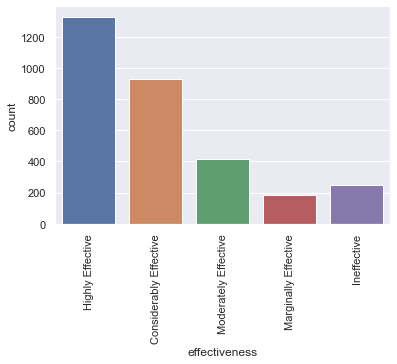

In [444]:
a = sns.countplot(x='effectiveness', data=train_data_benefits,
              order=['Highly Effective', 'Considerably Effective', 'Moderately Effective', 'Marginally Effective', 'Ineffective'])
a.set_xticklabels(a.get_xticklabels(), rotation=90)


In [29]:
side = pd.DataFrame(train_data_side_effects['side_effects'].value_counts())
side.reset_index(inplace=True)
side.rename(columns={'index': 'side_effects', 'side_effects': 'count'}, inplace=True)
side['%Reviews'] = round((side['count'] / side['count'].sum()) * 100, 2)
side.sort_values(by='%Reviews', ascending=False)

,side_effects,count,%Reviews
0,Mild Side Effects,1019,32.80
1,No Side Effects,930,29.93
2,Moderate Side Effects,614,19.76
3,Severe Side Effects,369,11.88
4,Extremely Severe Side Effects,175,5.63


[Text(0, 0, 'Extremely Severe Side Effects'),
 Text(1, 0, 'Severe Side Effects'),
 Text(2, 0, 'Moderate Side Effects'),
 Text(3, 0, 'Mild Side Effects'),
 Text(4, 0, 'No Side Effects')]

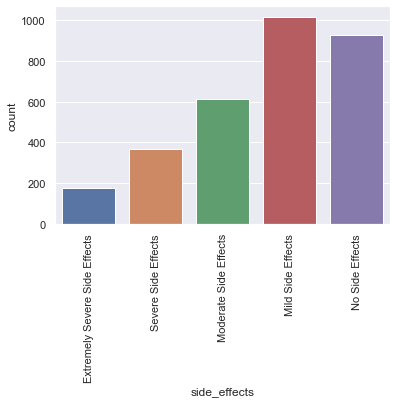

In [443]:
a = sns.countplot(x='side_effects', data=train_data_side_effects,
              order=['Extremely Severe Side Effects', 'Severe Side Effects', 'Moderate Side Effects', 'Mild Side Effects', 'No Side Effects'])
a.set_xticklabels(a.get_xticklabels(), rotation=90)


As expected, there is a significant skew in the data. There are two possible solutions for this effect. One is undersampling the data and the other is oversampling it.

There is also a discussion in wether or not we should balance the dataset since the reviews in the real world will also be skewed towards higher ratings. Therefore, we will test both sampling methods as wel as using unsampled data.

### Over and under sampling the data

In [31]:
def undersample(df, column, labels, sample_size):
    
    a = df[df[column] == labels[0]].sample(n=sample_size)
    b = df[df[column] == labels[1]].sample(n=sample_size)
    c = df[df[column] == labels[2]].sample(n=sample_size)
    d = df[df[column] == labels[3]].sample(n=sample_size)
    e = df[df[column] == labels[4]].sample(n=sample_size)
    
    final_df = pd.concat([a, b, c, d, e], ignore_index = True).copy()
    return final_df

In [32]:
labels = train_data_benefits['effectiveness'].unique().tolist()

undersample_benefits = undersample(train_data_benefits, 'effectiveness', labels,187).copy()
#under_sample_benefits

In [33]:
labels = train_data_side_effects['side_effects'].unique().tolist()
undersample_side_effects = undersample(train_data_side_effects, 'side_effects', labels, 175).copy()
#under_sample_side_effects


In [34]:
def oversample(X,y):
    sm = SMOTE(sampling_strategy='all')
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

### Choosing the best classifier

The problem of predicting a rating from text can be approached as a classification or as a regression problem. However, according to the researchers of the following paper, the best results are achieved when we treat it as a classification problem.

https://aclanthology.org/W10-1205/

In [36]:
def find_model(X, y):
    results = {}

    pipeline_1 = Pipeline([
        ('vect1', TfidfVectorizer()),
        ('clf1', SVC()),
    ])

    pipeline_2 = Pipeline([
        ('vect2', TfidfVectorizer()),
        ('clf2', RandomForestClassifier()),
    ])

    param_grid_1 = {
        'vect1__max_df': [0.75, 1.0],
        'vect1__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (3, 3)],
        'vect1__use_idf': [True, False],
        'vect1__norm': ['l1', 'l2', None],
        
        'clf1__C': [0.1, 1, 10, 100],
        'clf1__gamma': [1, 0.1, 0.01, 0.001],
        'clf1__kernel': ['rbf', 'poly']
        }

    param_grid_2 = {
        'vect2__max_df': [0.75, 1.0],
        'vect2__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (3, 3)],
        'vect2__use_idf': [True, False],
        'vect2__norm': ['l1', 'l2', None],

        'clf2__criterion': ['gini', 'entropy'],
        'clf2__max_depth': [2, 4, 6, 8, 10, 12]
    }

    clf_1 = HalvingGridSearchCV(estimator=pipeline_1, param_grid=param_grid_1, cv=5, n_jobs=-1)
    clf_2 = HalvingGridSearchCV(estimator=pipeline_2, param_grid=param_grid_2, cv=5, n_jobs=-1)
    
    clf_1.fit(X, y)
    clf_2.fit(X, y)

    results['svc'] = {'score': clf_1.best_score_, 'params': clf_1.best_params_}
    results['tree'] = {'score': clf_2.best_score_, 'params': clf_2.best_params_}
    
    return results


## Benefits Reviews

In [37]:
X = train_data_benefits['benefits_review'].copy()
y = train_data_benefits['effectiveness'].copy()
le = LabelEncoder()
y = le.fit_transform(y)

In [38]:
best_classifier = find_model(X, y)
best_classifier

{'svc': {'score': 0.45207765386204046,
  'params': {'clf1__C': 100,
   'clf1__gamma': 0.1,
   'clf1__kernel': 'rbf',
   'vect1__max_df': 1.0,
   'vect1__ngram_range': (1, 3),
   'vect1__norm': 'l1',
   'vect1__use_idf': False}},
 'tree': {'score': 0.45802560925237507,
  'params': {'clf2__criterion': 'gini',
   'clf2__max_depth': 12,
   'vect2__max_df': 0.75,
   'vect2__ngram_range': (1, 1),
   'vect2__norm': 'l2',
   'vect2__use_idf': False}}}

#### Original dataset

In [376]:
tfidf = TfidfVectorizer(ngram_range=(1,3), norm='l2', use_idf=True, max_df=0.75)
le = LabelEncoder()

X_train_ben = train_data_benefits['benefits_review'].copy()
y_train_ben = train_data_benefits['effectiveness'].copy()
y_train_ben = le.fit_transform(y_train_ben)

X_test_ben = test_data_benefits['benefits_review'].copy()
y_test_ben = test_data_benefits['effectiveness'].copy()
y_test_ben = le.fit_transform(y_test_ben)

X_train_ben = tfidf.fit_transform(X_train_ben)
X_test_ben = tfidf.transform(X_test_ben)

clf_benefits = SVC(C=1, gamma=1, kernel='rbf')
clf_benefits.fit(X_train_ben, y_train_ben)
y_pred_ben = clf_benefits.predict(X_test_ben)

y_test_ben = le.inverse_transform(y_test_ben)
y_pred_ben = le.inverse_transform(y_pred_ben)

print(metrics.classification_report(y_test_ben, y_pred_ben, zero_division=0))

                        precision    recall  f1-score   support

Considerably Effective       0.49      0.11      0.17       310
      Highly Effective       0.43      0.97      0.59       411
           Ineffective       0.87      0.24      0.38        82
  Marginally Effective       0.00      0.00      0.00        76
  Moderately Effective       0.75      0.06      0.11       157

              accuracy                           0.44      1036
             macro avg       0.51      0.27      0.25      1036
          weighted avg       0.50      0.44      0.33      1036



#### Undersampled

In [40]:
X_train_ben = undersample_benefits['benefits_review'].copy()
y_train_ben = undersample_benefits['effectiveness'].copy()
y_train_ben = le.fit_transform(y_train_ben)

X_test_ben = test_data_benefits['benefits_review'].copy()
y_test_ben = test_data_benefits['effectiveness'].copy()
y_test_ben = le.fit_transform(y_test_ben)

X_train_ben = tfidf.fit_transform(X_train_ben)
X_test_ben = tfidf.transform(X_test_ben)


clf_benefits = SVC(C=1, gamma=1, kernel='rbf')
clf_benefits.fit(X_train_ben, y_train_ben)
y_pred_ben = clf_benefits.predict(X_test_ben)

y_test_ben = le.inverse_transform(y_test_ben)
y_pred_ben = le.inverse_transform(y_pred_ben)

print(metrics.classification_report(y_test_ben, y_pred_ben))


                        precision    recall  f1-score   support

Considerably Effective       0.36      0.40      0.38       310
      Highly Effective       0.53      0.48      0.51       411
           Ineffective       0.61      0.52      0.56        82
  Marginally Effective       0.26      0.13      0.18        76
  Moderately Effective       0.23      0.31      0.27       157

              accuracy                           0.41      1036
             macro avg       0.40      0.37      0.38      1036
          weighted avg       0.42      0.41      0.41      1036



#### Oversampled

In [41]:
X_train_ben = train_data_benefits['benefits_review'].copy()
y_train_ben = train_data_benefits['effectiveness'].copy()
y_train_ben = le.fit_transform(y_train_ben)

X_test_ben = test_data_benefits['benefits_review'].copy()
y_test_ben = test_data_benefits['effectiveness'].copy()
y_test_ben = le.fit_transform(y_test_ben)

X_train_ben = tfidf.fit_transform(X_train_ben)
X_test_ben = tfidf.transform(X_test_ben)

X_train_ben, y_train_ben = oversample(X_train_ben, y_train_ben)

clf_benefits = SVC(C=1, gamma=1, kernel='rbf')
clf_benefits.fit(X_train_ben, y_train_ben)
y_pred_ben = clf_benefits.predict(X_test_ben)

y_test_ben = le.inverse_transform(y_test_ben)
y_pred_ben = le.inverse_transform(y_pred_ben)

print(metrics.classification_report(y_test_ben, y_pred_ben))

                        precision    recall  f1-score   support

Considerably Effective       0.46      0.13      0.21       310
      Highly Effective       0.43      0.95      0.60       411
           Ineffective       0.80      0.29      0.43        82
  Marginally Effective       1.00      0.01      0.03        76
  Moderately Effective       0.56      0.06      0.10       157

              accuracy                           0.45      1036
             macro avg       0.65      0.29      0.27      1036
          weighted avg       0.53      0.45      0.35      1036



### Conclusion

- The best results were achieved when using the oversampled dataset, which provided the model with more data to learn how to make the classifications.
- In terms of text pre-processing, the best results were achieved when using n-grams with sizes between 1 and 3 (combination of uni, bi and tri-grams).
- The classifier that produced the best results was the SVC.

## Side Effects Reviews

In [42]:
X = train_data_side_effects['side_effects_review'].copy()
y = train_data_side_effects['side_effects'].copy()
le = LabelEncoder()
y = le.fit_transform(y)

In [43]:
best_classifier = find_model(X, y)
best_classifier

{'svc': {'score': 0.5597879664050669,
  'params': {'clf1__C': 100,
   'clf1__gamma': 0.01,
   'clf1__kernel': 'rbf',
   'vect1__max_df': 0.75,
   'vect1__ngram_range': (1, 2),
   'vect1__norm': 'l2',
   'vect1__use_idf': False}},
 'tree': {'score': 0.5241057414291616,
  'params': {'clf2__criterion': 'entropy',
   'clf2__max_depth': 12,
   'vect2__max_df': 0.75,
   'vect2__ngram_range': (1, 1),
   'vect2__norm': None,
   'vect2__use_idf': True}}}

#### Original dataset

In [44]:
tfidf_2 = TfidfVectorizer(ngram_range=(1,2), norm=None, use_idf=True, max_df=0.75)
le = LabelEncoder()

X_train_side = train_data_side_effects['side_effects_review'].copy()
y_train_side = train_data_side_effects['side_effects'].copy()
y_train_side = le.fit_transform(y_train_side)

X_test_side = test_data_side_effects['side_effects_review'].copy()
y_test_side = test_data_side_effects['side_effects'].copy()
y_test_side = le.fit_transform(y_test_side)

X_train_side = tfidf_2.fit_transform(X_train_side)
X_test_side = tfidf_2.transform(X_test_side)

clf_side = SVC(C=10, gamma=0.01, kernel='rbf')
clf_side.fit(X_train_side, y_train_side)
y_pred_side = clf_side.predict(X_test_side)

y_test_side = le.inverse_transform(y_test_side)
y_pred_side = le.inverse_transform(y_pred_side)

print(metrics.classification_report(y_test_side, y_pred_side))

                               precision    recall  f1-score   support

Extremely Severe Side Effects       0.42      0.16      0.23        80
            Mild Side Effects       0.52      0.68      0.59       330
        Moderate Side Effects       0.42      0.32      0.37       236
              No Side Effects       0.77      0.75      0.76       268
          Severe Side Effects       0.34      0.36      0.35       122

                     accuracy                           0.54      1036
                    macro avg       0.49      0.46      0.46      1036
                 weighted avg       0.53      0.54      0.53      1036



#### Undersampled

In [72]:
X_train_side = undersample_side_effects['side_effects_review'].copy()
y_train_side = undersample_side_effects['side_effects'].copy()
y_train_side = le.fit_transform(y_train_side)

X_test_side = test_data_side_effects['side_effects_review'].copy()
y_test_side = test_data_side_effects['side_effects'].copy()
y_test_side = le.fit_transform(y_test_side)

X_train_side = tfidf.fit_transform(X_train_side)
X_test_side = tfidf.transform(X_test_side)

clf_side = SVC(C=1, gamma=1, kernel='rbf')
clf_side.fit(X_train_side, y_train_side)
y_pred_side = clf_side.predict(X_test_side)

y_test_side = le.inverse_transform(y_test_side)
y_pred_side = le.inverse_transform(y_pred_side)

print(metrics.classification_report(y_test_side, y_pred_side))


                               precision    recall  f1-score   support

Extremely Severe Side Effects       0.27      0.60      0.37        80
            Mild Side Effects       0.64      0.49      0.56       330
        Moderate Side Effects       0.34      0.36      0.35       236
              No Side Effects       0.85      0.64      0.73       268
          Severe Side Effects       0.19      0.23      0.21       122

                     accuracy                           0.48      1036
                    macro avg       0.46      0.46      0.44      1036
                 weighted avg       0.54      0.48      0.50      1036



#### Oversampled

In [45]:
X_train_side = train_data_side_effects['side_effects_review'].copy()
y_train_side = train_data_side_effects['side_effects'].copy()
y_train_side = le.fit_transform(y_train_side)

X_test_side = test_data_side_effects['side_effects_review'].copy()
y_test_side = test_data_side_effects['side_effects'].copy()
y_test_side = le.fit_transform(y_test_side)

X_train_side = tfidf_2.fit_transform(X_train_side)
X_test_side = tfidf_2.transform(X_test_side)

X_train_side, y_train_side = oversample(X_train_side, y_train_side)

clf_side = SVC(C=10, gamma=0.001, kernel='rbf')
clf_side.fit(X_train_side, y_train_side)
y_pred_side = clf_side.predict(X_test_side)

y_test_side = le.inverse_transform(y_test_side)
y_pred_side = le.inverse_transform(y_pred_side)

print(metrics.classification_report(y_test_side, y_pred_side))

                               precision    recall  f1-score   support

Extremely Severe Side Effects       0.26      0.19      0.22        80
            Mild Side Effects       0.52      0.62      0.56       330
        Moderate Side Effects       0.39      0.34      0.36       236
              No Side Effects       0.79      0.74      0.76       268
          Severe Side Effects       0.34      0.37      0.35       122

                     accuracy                           0.52      1036
                    macro avg       0.46      0.45      0.45      1036
                 weighted avg       0.52      0.52      0.52      1036



### Conclusion

- Contrary to the benefits reviews, the best results were achieved when using the original dataset.
- In terms of text pre-processing, the best results were achieved when using a combination of uni and bi-grams.
- The classifier that produced the best results was, again, the SVC.

## Type of Review

In [46]:
X = type_of_text['review'].copy()
y = type_of_text['category'].copy()
le = LabelEncoder()
y = le.fit_transform(y)

In [47]:
best_classifier = find_model(X, y)
best_classifier

{'svc': {'score': 0.7820461835535935,
  'params': {'clf1__C': 10,
   'clf1__gamma': 0.1,
   'clf1__kernel': 'rbf',
   'vect1__max_df': 0.75,
   'vect1__ngram_range': (1, 2),
   'vect1__norm': 'l2',
   'vect1__use_idf': True}},
 'tree': {'score': 0.721805440112249,
  'params': {'clf2__criterion': 'entropy',
   'clf2__max_depth': 12,
   'vect2__max_df': 1.0,
   'vect2__ngram_range': (1, 1),
   'vect2__norm': 'l2',
   'vect2__use_idf': False}}}

#### Original dataset

In [48]:
tfidf = TfidfVectorizer(ngram_range=(1,2), norm='l2', use_idf=True, max_df=0.75)
le = LabelEncoder()

X_train_type = type_of_text['review'].copy()
y_train_type = type_of_text['category'].copy()
y_train_type = le.fit_transform(y_train_type)

X_test_type = type_of_text_test['review'].copy()
y_test_type = type_of_text_test['category'].copy()
y_test_type = le.fit_transform(y_test_type)

X_train_type = tfidf.fit_transform(X_train_type)
X_test_type = tfidf.transform(X_test_type)

clf_type = SVC(C=10, gamma=0.1, kernel='rbf')
clf_type.fit(X_train_type, y_train_type)
y_pred_type = clf_type.predict(X_test_type)

y_test_type = le.inverse_transform(y_test_type)
y_pred_type = le.inverse_transform(y_pred_type)

print(metrics.classification_report(y_test_type, y_pred_type))

              precision    recall  f1-score   support

    Benefits       0.99      0.98      0.99      3107
     General       1.00      0.99      0.99      3107
Side Effects       0.98      1.00      0.99      3107

    accuracy                           0.99      9321
   macro avg       0.99      0.99      0.99      9321
weighted avg       0.99      0.99      0.99      9321



### Conclusion

- It didn't make sense for us to sample this dataset as it is balanced by nature (33% for each class), due to the way it was created.
- In terms of text pre-processing, the best results were achieved when using a combination of uni and bi-grams.
- The classifier that produced the best results was, again, the SVC.
- In this classifier, the results achieved were far higher than the ones achieved by the previous ones.
- This could be explained by the higher ammount of data to train the dataset.
- Furthermore, the words used in different types of reviews are more distinct between themselves than the words used on the same type of review for different levels of satisfaction.

## Testing on the drugsCom dataset

### Benefits

In [49]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), norm='l2', use_idf=True, max_df=0.75)
le = LabelEncoder()

X_ben = final_data['benefits_review'].copy()
y_ben = final_data['effectiveness'].copy()
y_ben = le.fit_transform(y_ben)

X_test_ben = similar_data['review'].copy()

X_ben = tfidf.fit_transform(X_ben)
X_test_ben = tfidf.transform(X_test_ben)

clf_benefits = SVC(C=1, gamma=1, kernel='rbf')
clf_benefits.fit(X_ben, y_ben)
y_pred_ben = clf_benefits.predict(X_test_ben)

y_pred_ben = le.inverse_transform(y_pred_ben)

similar_data['effectiveness'] = y_pred_ben


In [84]:
ben_2 = pd.DataFrame(similar_data['effectiveness'].value_counts())
ben_2.reset_index(inplace=True)
ben_2.rename(columns={'index': 'effectiveness', 'effectiveness': 'count'}, inplace=True)
ben_2['%Reviews'] = round((ben_2['count'] / ben_2['count'].sum()) * 100, 2)
ben_2.sort_values(by='%Reviews', ascending=False)


,effectiveness,count,%Reviews
0,Highly Effective,212185,99.21
1,Considerably Effective,1603,0.75
2,Moderately Effective,60,0.03
3,Ineffective,20,0.01
4,Marginally Effective,1,0.00


[Text(0, 0, 'Highly Effective'),
 Text(1, 0, 'Considerably Effective'),
 Text(2, 0, 'Moderately Effective'),
 Text(3, 0, 'Marginally Effective'),
 Text(4, 0, 'Ineffective')]

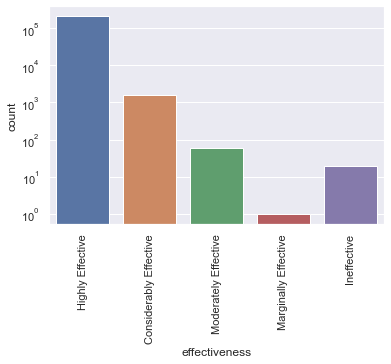

In [442]:
a = sns.countplot(x='effectiveness', data=similar_data,
              order=['Highly Effective', 'Considerably Effective', 'Moderately Effective', 'Marginally Effective', 'Ineffective'], log=True)
a.set_xticklabels(a.get_xticklabels(), rotation=90)


### Side Effects

In [51]:
tfidf_2 = TfidfVectorizer(ngram_range=(1, 1), norm=None, use_idf=True, max_df=0.75)
le = LabelEncoder()

X_train_side = final_data['side_effects_review'].copy()
y_train_side = final_data['side_effects'].copy()
y_train_side = le.fit_transform(y_train_side)

X_test_side = similar_data['review'].copy()

X_train_side = tfidf_2.fit_transform(X_train_side)
X_test_side = tfidf_2.transform(X_test_side)

clf_side = SVC(C=10, gamma=0.001, kernel='rbf')
clf_side.fit(X_train_side, y_train_side)
y_pred_side = clf_side.predict(X_test_side)

y_pred_side = le.inverse_transform(y_pred_side)

similar_data['side_effects'] = y_pred_side

In [83]:
side_2 = pd.DataFrame(similar_data['side_effects'].value_counts())
side_2.reset_index(inplace=True)
side_2.rename(columns={'index': 'side_effects', 'side_effects': 'count'}, inplace=True)
side_2['%Reviews'] = round((side_2['count'] / side_2['count'].sum()) * 100, 2)
side_2.sort_values(by='%Reviews', ascending=False)

,side_effects,count,%Reviews
0,Moderate Side Effects,72987,34.13
1,Mild Side Effects,56662,26.49
2,Severe Side Effects,42650,19.94
3,Extremely Severe Side Effects,23945,11.20
4,No Side Effects,17625,8.24


[Text(0, 0, 'Extremely Severe Side Effects'),
 Text(1, 0, 'Severe Side Effects'),
 Text(2, 0, 'Moderate Side Effects'),
 Text(3, 0, 'Mild Side Effects'),
 Text(4, 0, 'No Side Effects')]

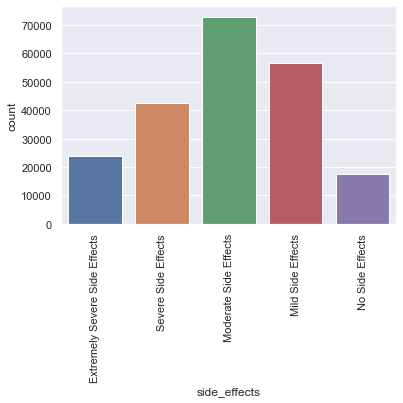

In [441]:
a = sns.countplot(x='side_effects', data=similar_data,
              order=['Extremely Severe Side Effects', 'Severe Side Effects', 'Moderate Side Effects', 'Mild Side Effects', 'No Side Effects'])
a.set_xticklabels(a.get_xticklabels(), rotation=90)


### Type of text

In [53]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), norm='l2', use_idf=True, max_df=0.75)
le = LabelEncoder()

X_train_type = type_of_text_final['review'].copy()
y_train_type = type_of_text_final['category'].copy()
y_train_type = le.fit_transform(y_train_type)

X_test_type = similar_data['review'].copy()

X_train_type = tfidf.fit_transform(X_train_type)
X_test_type = tfidf.transform(X_test_type)

clf_type = SVC(C=10, gamma=1, kernel='rbf')
clf_type.fit(X_train_type, y_train_type)
y_pred_type = clf_type.predict(X_test_type)

y_pred_type = le.inverse_transform(y_pred_type)

similar_data['type'] = y_pred_type

In [63]:
type_2 = pd.DataFrame(similar_data['type'].value_counts())
type_2.reset_index(inplace=True)
type_2.rename(columns={'index': 'type', 'type': 'count'}, inplace=True)
type_2['%Reviews'] = round((type_2['count'] / type_2['count'].sum()) * 100, 2)
type_2.sort_values(by='%Reviews', ascending=False)

,type,count,%Reviews
0,General,104189,48.72
1,Side Effects,55335,25.87
2,Benefits,54345,25.41


[Text(0, 0, 'General'), Text(1, 0, 'Benefits'), Text(2, 0, 'Side Effects')]

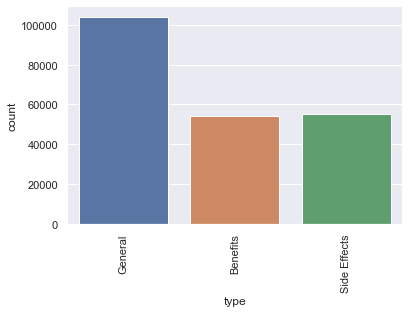

In [436]:
a = sns.countplot(x='type', data=similar_data)
a.set_xticklabels(a.get_xticklabels(), rotation=90)


### Conclusions

- This dataset doesn't possess labels so, in order to evaluate the results, we will be assessing the % of entries classified as each class.
- The benefits review classifier performed the worst, classifing almost all of the reviews as Highly Effective (99.2% on the DrugsCom dataset compared to 42% on the orignal dataset)
- The results obtained by the side effects classifier were more inline with the results obtained on the original dataset.
- It classified more reviews as 'Moderate Side Effects' and less reviews as 'No Side Effects', but apart from this the results were as expected 
- The type of text classifier also performed as expected. 
- It classified a bit more reviews as General than expected, but the variation is small.

In [79]:
df1_styler = effective.style.set_table_attributes("style='display:inline'").set_caption('DrugsRaw Dataset')
df2_styler = ben_2.style.set_table_attributes("style='display:inline'").set_caption('DrugsCom Dataset')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,effectiveness,count,%Reviews
0,Highly Effective,1330,42.810000
1,Considerably Effective,928,29.870000
2,Moderately Effective,415,13.360000
3,Ineffective,247,7.950000
4,Marginally Effective,187,6.020000
,effectiveness,count,%Reviews
0,Highly Effective,212185,99.210000
1,Considerably Effective,1603,0.750000
2,Moderately Effective,60,0.030000
3,Ineffective,20,0.010000


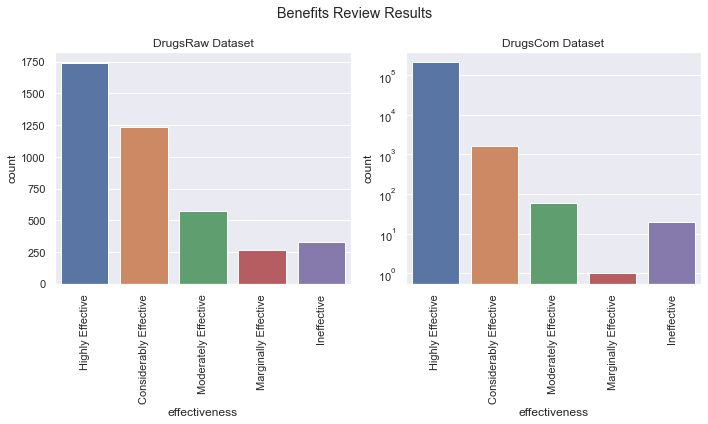

In [435]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('Benefits Review Results')

sns.countplot(ax=axes[0], x='effectiveness', data=final_data,
              order=['Highly Effective', 'Considerably Effective', 'Moderately Effective', 'Marginally Effective', 'Ineffective'])
axes[0].set_title('DrugsRaw Dataset')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.countplot(ax=axes[1], x='effectiveness', data=similar_data,
              order=['Highly Effective', 'Considerably Effective', 'Moderately Effective', 'Marginally Effective', 'Ineffective'], log=True)
axes[1].set_title('DrugsCom Dataset')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

fig.tight_layout()

In [80]:
df3_styler = side.style.set_table_attributes(
    "style='display:inline'").set_caption('DrugsRaw Dataset')
df4_styler = side_2.style.set_table_attributes(
    "style='display:inline'").set_caption('DrugsCom Dataset')

display_html(df3_styler._repr_html_()+df4_styler._repr_html_(), raw=True)


,side_effects,count,%Reviews
0,Mild Side Effects,1019,32.800000
1,No Side Effects,930,29.930000
2,Moderate Side Effects,614,19.760000
3,Severe Side Effects,369,11.880000
4,Extremely Severe Side Effects,175,5.630000
,side_effects,count,%Reviews
0,Moderate Side Effects,72987,34.130000
1,Mild Side Effects,56662,26.490000
2,Severe Side Effects,42650,19.940000
3,Extremely Severe Side Effects,23945,11.200000


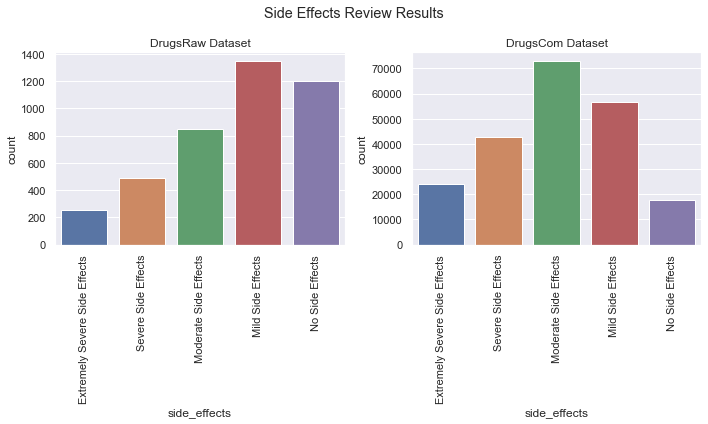

In [433]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Side Effects Review Results')

sns.countplot(ax=axes[0], x='side_effects', data=final_data,
              order=['Extremely Severe Side Effects', 'Severe Side Effects', 'Moderate Side Effects', 'Mild Side Effects', 'No Side Effects'])
axes[0].set_title('DrugsRaw Dataset')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.countplot(ax=axes[1], x='side_effects', data=similar_data,
              order=['Extremely Severe Side Effects', 'Severe Side Effects', 'Moderate Side Effects', 'Mild Side Effects', 'No Side Effects'])
axes[1].set_title('DrugsCom Dataset')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
fig.tight_layout()


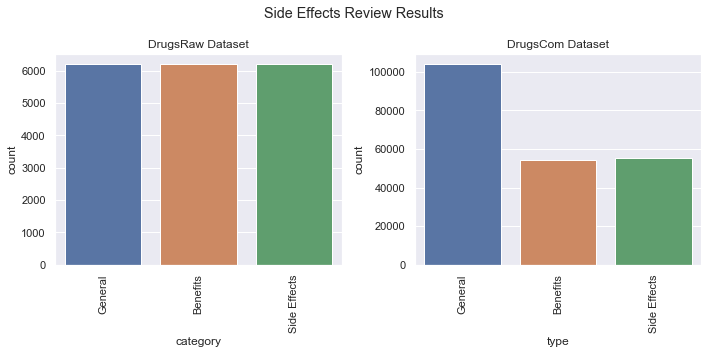

In [422]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Side Effects Review Results')

sns.countplot(ax=axes[0], x='category', data=type_of_text_final, order=['General', 'Benefits', 'Side Effects'])
axes[0].set_title('DrugsRaw Dataset')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.countplot(ax=axes[1], x='type', data=similar_data,
              order=['General', 'Benefits', 'Side Effects'])
axes[1].set_title('DrugsCom Dataset')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

fig.tight_layout()

## Sentiment Analysis

The sentiment analysis will be performed on the DrugsCom dataset, as it has only one review field, making it more probable that this field contains useful reviews for a sentiment analysis.

In [343]:
# Preparing the similar dataset to be used
data_3 = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv', sep='\t', header=0, names=[
                        'id', 'drug', 'condition', 'review', 'rating', 'date', 'useful_count'])
data_3.dropna(inplace=True)

data_4 = pd.read_csv('drugsCom_raw/drugsComTest_raw.tsv', sep='\t', header=0, names=[
    'id', 'drug', 'condition', 'review', 'rating', 'date', 'useful_count'])

data_4.dropna(inplace=True)
sentiment_data = pd.concat([data_3, data_4], ignore_index=True).copy()
sentiment_data.drop(columns=['id', 'condition', 'date', 'rating','useful_count'], inplace=True)
sentiment_data['review'] = sentiment_data['review'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http+?", "", elem))
sentiment_data

,drug,review
0,Valsartan,It has no side effect I take it in combination...
1,Guanfacine,My son is halfway through his fourth week of I...
2,Lybrel,I used to take another oral contraceptive whic...
3,Ortho Evra,This is my first time using any form of birth ...
4,Buprenorphine / naloxone,Suboxone has completely turned my life around ...
...,...,...
213864,Tamoxifen,I have taken Tamoxifen for 5 years Side effect...
213865,Escitalopram,I039ve been taking Lexapro escitaploprgram sin...
213866,Levonorgestrel,I039m married 34 years old and I have no kids ...
213867,Tapentadol,I was prescribed Nucynta for severe neckshould...


In [377]:
analyzer = SentimentIntensityAnalyzer()
sentiment_data_2 = sentiment_data.copy()
sentiment_data_2['sentiment_val'] = sentiment_data_2['review'].apply(lambda x: median([analyzer.polarity_scores(sentence)['compound'] for sentence in x.split('.')]))

In [378]:
sentiment_data_2['sentiment'] = sentiment_data_2['sentiment_val'].apply(lambda x: 'positive' if x >= 0.05 else('negative' if x <= -0.05 else 'neutral'))

In [379]:
# Auxiliar column just to count the number of positive and negative reviews per drug without the problems that using count brings 
sentiment_data_2['count'] = 1
# Grouping the rows by drug and sentiment and counting how many positive, negative and neutral reviews exist per drug
aux = sentiment_data_2.groupby(by=['drug', 'sentiment'], as_index=False).sum()
# Creating an auxiliar dataframe to get one column per sentiment instead of column with all the sentiments mixed in
aux['positive'] = aux.loc[aux['sentiment'] == 'positive']['count']
aux['negative'] = aux.loc[aux['sentiment'] == 'negative']['count']
aux['neutral'] = aux.loc[aux['sentiment'] == 'neutral']['count']

# The rows of the table have the following layout:
#
#  drug      sentiment    positive    negative
#   xpto      positive       5         NaN
#   xpto      negative      NaN         2
#
# By setting the entries of the sentiments column to aux, we can melt those rows into a single one.
aux['sentiment'] = 'aux'

# Melting the rows together
drug_sentiment = aux.groupby(['drug', 'sentiment'], as_index=False).first()
# Some NaNs appeared in rows that didn't have positive/negative/neutral reviews before the melting 
# so we will be removing them by filling them with 0.
drug_sentiment.fillna(0, inplace=True)
# Droping unused columns
drug_sentiment.drop(columns=['sentiment', 'sentiment_val', 'count'], inplace=True)
# Calculating the percentage of positive and negative reviews for each drug
drug_sentiment['%Positive'] = round((drug_sentiment['positive'] / (drug_sentiment['positive'] + drug_sentiment['negative'] + drug_sentiment['neutral'])) * 100, 2)
drug_sentiment['%Negative'] = round((drug_sentiment['negative'] / (drug_sentiment['positive'] + drug_sentiment['negative'] + drug_sentiment['neutral'])) * 100, 2)


In [385]:
# Calculating the median number of reviews per drug so that we set a minimun threshold
sentiment_data_2['drug'].value_counts().median()

6.0

In [386]:
# Selecting only the drugs that have more than 10 reviews
top_drug_sentiment = drug_sentiment[(drug_sentiment['positive'] + drug_sentiment['negative']) >= 10].copy()

# Ordering the table by the drugs with a higher percentage of negative reviews first
top_drug_sentiment.sort_values(by='%Negative', ascending=False, inplace=True, ignore_index=True)
top_drug_sentiment

,drug,positive,negative,neutral,%Positive,%Negative
0,Trimethoprim,1.0,13.0,0.0,7.14,92.86
1,Opdivo,1.0,13.0,0.0,7.14,92.86
2,Perindopril,1.0,9.0,0.0,10.00,90.00
3,Levsin,1.0,9.0,0.0,10.00,90.00
4,Hydralazine,2.0,17.0,0.0,10.53,89.47
...,...,...,...,...,...,...
1490,Estazolam,12.0,1.0,1.0,85.71,7.14
1491,Econazole,12.0,1.0,1.0,85.71,7.14
1492,Tazarotene,14.0,0.0,2.0,87.50,0.00
1493,Privine,10.0,0.0,1.0,90.91,0.00


In [417]:
# Top 30 drugs that receive the most negative reviews
top_30 = top_drug_sentiment.head(30)

### Displaying the 30 drugs that have the highest percentage of negative reviews

Text(0.5, 1.0, 'Top 30 drugs with most negative reviews')

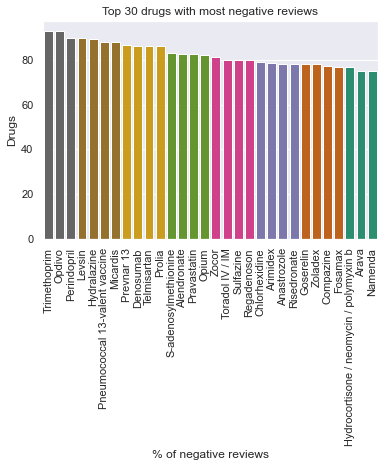

In [464]:
a = sns.barplot(data=top_30, x='drug', y='%Negative', palette="Dark2_r")
a.set_xlabel('% of negative reviews')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_ylabel('Drugs')
a.set_title('Top 30 drugs with most negative reviews')